## 2 phase model
(1) Classify images into [one class] and [the other two classes]

(2) If an image is classified as [the other two classes] use a second model to distinguish between the two

## Initialization

In [ ]:
import os
from datetime import datetime
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Start from same seed so that the expirements will always be the same.
m_seed = 1234
tf.random.set_seed(m_seed)
np.random.seed(m_seed)

# Custom variables.
m_batch_size = 64
m_img_h = 256 # Height of the image.
m_img_w = 256 # Width of the image.
m_num_classes = 2
m_resize_size = (256,256)
m_rescale = 1/255 # Rescale to bring the color from the [0, 255] range to the [0, 1] range.
m_validation_split = 0.20 # 20 % of the training images will be used for validation.
m_regularizer_value = 0.001

# Settings
enable_early_stop = True
enable_finetuning = True
enable_validation_set = True
enable_model_checkpoint = False # Disabled due to much storage utilization on Google Drive.
reduce_lr_on_plateau = True
adaptive_learning_rate = False

## Mount google drive and prepare directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/Colab Data/artificial-neural-networks-and-deep-learning-2020'

cwd = os.getcwd()
print(cwd)
dataset_dir = os.path.join(cwd, 'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')
exps_dir = os.path.join(cwd, 'drive/My Drive/Colab Data/classification_experiments_')
exp_dir = os.path.join(exps_dir, 'homework1_' + str(datetime.now().strftime('%b%d_%H-%M-%S')))
ckpt_dir = os.path.join(exp_dir, 'ckpts')
tb_dir = os.path.join(exp_dir, 'tb_logs')

!ls ./drive/My\ Drive/Colab\ Data/custom\ dataset
print(cwd)
custom_data_dir = os.path.join(cwd,"drive/My Drive/Colab Data/custom dataset")
os.listdir(custom_data_dir)

if not os.path.exists(exps_dir):
  os.makedirs(exps_dir)
if not os.path.exists(exp_dir):
  os.makedirs(exp_dir)
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
if not os.path.exists(tb_dir):
  os.makedirs(tb_dir)

## Extract labels

In [ ]:
# Labels are saved in the "train_gt.json" file, we need to extract them.
import json
json_path = os.path.join(dataset_dir, 'train_gt.json')
# print(json_path)
with open(json_path, 'r') as f:
  json_data = json.load(f)
traindf = pd.DataFrame({'label': json_data})
traindf.head()
 
# Create "file" column with the index names.
traindf['file'] = traindf.index

#make a copy
traindf_int_labels = traindf[:]
traindf_without_none = traindf[:]

# Convert labels from int to string.
def convert_to_label_name(label_int):
  if(label_int == 0):
    return "NO PERSON"
  elif(label_int == 1):
    return "ALL THE PEOPLE"
  else:
    return "SOMEONE"
traindf["label"] = traindf["label"].apply(convert_to_label_name)
 
print(traindf)
print(traindf_int_labels)
print(traindf_without_none)

                    label       file
10002.jpg         SOMEONE  10002.jpg
10003.jpg         SOMEONE  10003.jpg
10004.jpg  ALL THE PEOPLE  10004.jpg
10006.jpg  ALL THE PEOPLE  10006.jpg
10007.jpg  ALL THE PEOPLE  10007.jpg
...                   ...        ...
18199.jpg       NO PERSON  18199.jpg
18200.jpg         SOMEONE  18200.jpg
18201.jpg         SOMEONE  18201.jpg
18202.jpg       NO PERSON  18202.jpg
18204.jpg         SOMEONE  18204.jpg

[5614 rows x 2 columns]
           label       file
10002.jpg      2  10002.jpg
10003.jpg      2  10003.jpg
10004.jpg      1  10004.jpg
10006.jpg      1  10006.jpg
10007.jpg      1  10007.jpg
...          ...        ...
18199.jpg      0  18199.jpg
18200.jpg      2  18200.jpg
18201.jpg      2  18201.jpg
18202.jpg      0  18202.jpg
18204.jpg      2  18204.jpg

[5614 rows x 2 columns]
           label       file
10002.jpg      2  10002.jpg
10003.jpg      2  10003.jpg
10004.jpg      1  10004.jpg
10006.jpg      1  10006.jpg
10007.jpg      1  10007.jpg
..

### Adjust the data for training the two models

In [ ]:
# #make a dataframe where classes 'some' and 'all' are united
# def unite_some_all(label_int):
#   if(label_int == 0):
#     return "NO PERSON"
#   else:
#     return "SOME OR ALL"
# traindf_int_labels["label"] = traindf_int_labels["label"].apply(unite_some_all)
# print(traindf_int_labels)

In [ ]:
# #make a dataframe where classes 'none' and 'all' are united
# def unite_none_all(label_int):
#   if(label_int == 2):
#     return "SOME"
#   else:
#     return "NONE OR ALL"
# traindf_int_labels["label"] = traindf_int_labels["label"].apply(unite_none_all)
# print(traindf_int_labels)

In [ ]:
#make a dataframe where classes 'some' and 'none' are united
def unite_some_none(label_int):
  if(label_int == 1):
    return "ALL"
  else:
    return "SOME OR NONE"
traindf_int_labels["label"] = traindf_int_labels["label"].apply(unite_some_none)
print(traindf_int_labels)

                  label       file
10002.jpg  SOME OR NONE  10002.jpg
10003.jpg  SOME OR NONE  10003.jpg
10004.jpg           ALL  10004.jpg
10006.jpg           ALL  10006.jpg
10007.jpg           ALL  10007.jpg
...                 ...        ...
18199.jpg  SOME OR NONE  18199.jpg
18200.jpg  SOME OR NONE  18200.jpg
18201.jpg  SOME OR NONE  18201.jpg
18202.jpg  SOME OR NONE  18202.jpg
18204.jpg  SOME OR NONE  18204.jpg

[5614 rows x 2 columns]


In [ ]:
#make data frame without the 'all' class for training the second model
traindf_without_none = traindf_without_none[traindf_without_none.label != 1]
traindf_without_none["label"] = traindf_without_none["label"].apply(convert_to_label_name)
print(traindf_without_none)

               label       file
10002.jpg    SOMEONE  10002.jpg
10003.jpg    SOMEONE  10003.jpg
10009.jpg  NO PERSON  10009.jpg
10013.jpg    SOMEONE  10013.jpg
10016.jpg    SOMEONE  10016.jpg
...              ...        ...
18199.jpg  NO PERSON  18199.jpg
18200.jpg    SOMEONE  18200.jpg
18201.jpg    SOMEONE  18201.jpg
18202.jpg  NO PERSON  18202.jpg
18204.jpg    SOMEONE  18204.jpg

[3717 rows x 2 columns]


## Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Data/classification_experiments_/ --port 6010

## Callbacks

In [ ]:
callbacks = []

# Model checkpoint.
if enable_model_checkpoint:
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
      save_weights_only=True)
  print("Enabled model checkpoint.")
  callbacks.append(ckpt_callback)


# Visualize Learning on Tensorboard
# (by default it shows losses and metrics for both training and validation).
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tb_dir,
    profile_batch=0,
    histogram_freq=1) # if 1 shows weights histograms.
print("Enabled Tensorboard.")
callbacks.append(tb_callback)


# Early Stopping.
if enable_early_stop and enable_validation_set:
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights = True)
    print("Enabled Early Stopping")
    callbacks.append(es_callback)

#reduce learning rate on plateau(if validation loss is constant during training, reduce lr by an order of magnitude)
if reduce_lr_on_plateau:
  rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1E-7, verbose=1)
  callbacks.append(rlrp)

if adaptive_learning_rate:
  import math
  def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
   return lrate
  adaptive_lr = tf.keras.callbacks.LearningRateScheduler(step_decay)
  callbacks.append(adaptive_lr)

Enabled Tensorboard.
Enabled Early Stopping


## Image data generators with preprocessing (1)

In [ ]:
if enable_validation_set:
  train_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=5,
                                      height_shift_range=5,
                                      shear_range=0.1,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      fill_mode='constant', # Specifies what to do when pixel not present after transformation, like after a rotation.
                                      cval=0, # Value to put when filling a constant.
                                      rescale=m_rescale, # Normalization directly here instaed of later.
                                      validation_split=m_validation_split)
  valid_data_gen = ImageDataGenerator(rescale=m_rescale, validation_split=m_validation_split)
else:
  train_data_gen = ImageDataGenerator(rotation_range=5,
                                      width_shift_range=5,
                                      height_shift_range=5,
                                      shear_range=0.1,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      fill_mode='constant', # Specifies what to do when pixel not present after transformation, like after a rotation.
                                      cval=0, # Value to put when filling a constant.
                                      rescale=m_rescale, # Normalization directly here instaed of later.
                                      validation_split=0.0)
test_with_training_data_gen = ImageDataGenerator(rescale=m_rescale)

In [ ]:
train_gen=train_data_gen.flow_from_dataframe(
    dataframe=traindf_int_labels,
    directory=training_dir,
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=m_batch_size,
    seed=m_seed,
    shuffle=True,
    class_mode="categorical",
    target_size=m_resize_size
)
valid_gen=valid_data_gen.flow_from_dataframe(
    dataframe=traindf_int_labels,
    directory=training_dir,
    x_col="file",
    y_col="label",
    subset="validation",
    batch_size=m_batch_size,
    seed=m_seed,
    shuffle=True,
    class_mode="categorical",
    target_size=m_resize_size
)
test_with_training_gen=test_with_training_data_gen.flow_from_dataframe(
    dataframe=traindf_int_labels,
    directory=training_dir,
    x_col="file",
    y_col="label",
    batch_size=1, # We process image by image for testing.
    seed=m_seed,
    shuffle=False,
    class_mode="categorical",
    target_size=m_resize_size
)

Found 4492 validated image filenames belonging to 2 classes.
Found 1122 validated image filenames belonging to 2 classes.
Found 5614 validated image filenames belonging to 2 classes.


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, m_img_h, m_img_w, 3], [None, m_num_classes])) # "None" is the batch size dimension that we left unset to use dynamic batch size.
train_dataset = train_dataset.repeat()
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, m_img_h, m_img_w, 3], [None, m_num_classes])) # "None" is the batch size dimension that we left unset to use dynamic batch size.
valid_dataset = valid_dataset.repeat()

## Model 1

In [ ]:
# #part 1
# vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[m_img_h, m_img_w, 3])
 
# if enable_finetuning:
#     freeze_until = 15 # Layer from which we want to fine-tune.
#     for layer in vgg.layers[:freeze_until]:
#         layer.trainable = False
# else:
#     vgg.trainable = False
    
# model_1 = tf.keras.Sequential()
# model_1.add(vgg)
# model_1.add(tf.keras.layers.Flatten())
# model_1.add(tf.keras.layers.Dense(units=512, activation='relu'))
# model_1.add(tf.keras.layers.Dense(units=m_num_classes, activation='softmax'))
# model_1.summary()

# VGG16 architrecture taken from: https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
img_input = tf.keras.layers.Input(shape=[m_img_h, m_img_w, 3])
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(m_regularizer_value))(img_input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
vgg = tf.keras.Model(img_input, x, name='vgg16')
vgg.load_weights('/content/drive/My Drive/Colab Data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') # Weights downloaded from: https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
model_1 = tf.keras.Sequential()
model_1.add(vgg)
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(m_regularizer_value)))
model_1.add(tf.keras.layers.Dense(units=m_num_classes, activation='softmax', kernel_regularizer=l2(m_regularizer_value)))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 31,493,442
Trainable params: 31,493,442
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [ ]:
history = model_1.fit(x=train_dataset,
                    epochs=50,
                    steps_per_epoch=len(train_gen), # len(train_gen) already considers the batch size!
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen), # len(valid_gen) already considers the batch size!
                    callbacks=callbacks)

Epoch 1/50
71/71 [==============================] - 168s 2s/step - loss: 2.9981 - accuracy: 0.7620 - val_loss: 2.8784 - val_accuracy: 0.8209
Epoch 2/50
71/71 [==============================] - 167s 2s/step - loss: 2.8298 - accuracy: 0.8330 - val_loss: 2.8172 - val_accuracy: 0.8262
Epoch 3/50
71/71 [==============================] - 166s 2s/step - loss: 2.7229 - accuracy: 0.8687 - val_loss: 2.7238 - val_accuracy: 0.8565
Epoch 4/50
71/71 [==============================] - 167s 2s/step - loss: 2.6493 - accuracy: 0.8951 - val_loss: 2.6840 - val_accuracy: 0.8592
Epoch 5/50
71/71 [==============================] - 168s 2s/step - loss: 2.5908 - accuracy: 0.9052 - val_loss: 2.7359 - val_accuracy: 0.8431
Epoch 6/50
71/71 [==============================] - 169s 2s/step - loss: 2.5225 - accuracy: 0.9245 - val_loss: 2.6428 - val_accuracy: 0.8529
Epoch 7/50
71/71 [==============================] - 168s 2s/step - loss: 2.4621 - accuracy: 0.9463 - val_loss: 2.6222 - val_accuracy: 0.8725
Epoch 8/50
71

## Image data generators with preprocessing (2)

In [ ]:
if enable_validation_set:
  train_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=5,
                                      height_shift_range=5,
                                      shear_range=0.1,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      fill_mode='constant', # Specifies what to do when pixel not present after transformation, like after a rotation.
                                      cval=0, # Value to put when filling a constant.
                                      rescale=m_rescale, # Normalization directly here instaed of later.
                                      validation_split=m_validation_split)
  valid_data_gen = ImageDataGenerator(rescale=m_rescale, validation_split=m_validation_split)
else:
  train_data_gen = ImageDataGenerator(rotation_range=5,
                                      width_shift_range=5,
                                      height_shift_range=5,
                                      shear_range=0.1,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      fill_mode='constant', # Specifies what to do when pixel not present after transformation, like after a rotation.
                                      cval=0, # Value to put when filling a constant.
                                      rescale=m_rescale, # Normalization directly here instaed of later.
                                      validation_split=0.0)
test_with_training_data_gen = ImageDataGenerator(rescale=m_rescale)

In [ ]:
#same thing as above but for the second model which classifies some vs none
train_gen=train_data_gen.flow_from_dataframe(
    dataframe=traindf_without_none,
    directory=training_dir,
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=m_batch_size,
    seed=m_seed,
    shuffle=True,
    class_mode="categorical",
    target_size=m_resize_size
)
valid_gen=valid_data_gen.flow_from_dataframe(
    dataframe=traindf_without_none,
    directory=training_dir,
    x_col="file",
    y_col="label",
    subset="validation",
    batch_size=m_batch_size,
    seed=m_seed,
    shuffle=True,
    class_mode="categorical",
    target_size=m_resize_size
)
test_with_training_gen=test_with_training_data_gen.flow_from_dataframe(
    dataframe=traindf_without_none,
    directory=training_dir,
    x_col="file",
    y_col="label",
    batch_size=1, # We process image by image for testing.
    seed=m_seed,
    shuffle=False,
    class_mode="categorical",
    target_size=m_resize_size
)

Found 2974 validated image filenames belonging to 2 classes.
Found 743 validated image filenames belonging to 2 classes.
Found 3717 validated image filenames belonging to 2 classes.


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, m_img_h, m_img_w, 3], [None, m_num_classes])) # "None" is the batch size dimension that we left unset to use dynamic batch size.
train_dataset = train_dataset.repeat()
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, m_img_h, m_img_w, 3], [None, m_num_classes])) # "None" is the batch size dimension that we left unset to use dynamic batch size.
valid_dataset = valid_dataset.repeat()

## Model 2

In [ ]:
# #part 2
# vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[m_img_h, m_img_w, 3])
 
# if enable_finetuning:
#     freeze_until = 15 # Layer from which we want to fine-tune.
#     for layer in vgg.layers[:freeze_until]:
#         layer.trainable = False
# else:
#     vgg.trainable = False
    
# model_2 = tf.keras.Sequential()
# model_2.add(vgg)
# model_2.add(tf.keras.layers.Flatten())
# model_2.add(tf.keras.layers.Dense(units=512, activation='relu'))
# model_2.add(tf.keras.layers.Dense(units=m_num_classes, activation='softmax'))
# model_2.summary()

# VGG16 architrecture taken from: https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
img_input = tf.keras.layers.Input(shape=[m_img_h, m_img_w, 3])
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(m_regularizer_value))(img_input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
vgg = tf.keras.Model(img_input, x, name='vgg16')
vgg.load_weights('/content/drive/My Drive/Colab Data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') # Taken from: https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
model_2 = tf.keras.Sequential()
model_2.add(vgg)
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(m_regularizer_value)))
model_2.add(tf.keras.layers.Dense(units=m_num_classes, activation='softmax', kernel_regularizer=l2(m_regularizer_value)))
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 31,493,442
Trainable params: 31,493,442
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [ ]:
history = model_2.fit(x=train_dataset,
                    epochs=50,
                    steps_per_epoch=len(train_gen), # len(train_gen) already considers the batch size!
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen), # len(valid_gen) already considers the batch size!
                    callbacks=callbacks)

Epoch 1/50
47/47 [==============================] - 117s 2s/step - loss: 3.1585 - accuracy: 0.6116 - val_loss: 2.9350 - val_accuracy: 0.8102
Epoch 2/50
47/47 [==============================] - 111s 2s/step - loss: 2.8796 - accuracy: 0.8087 - val_loss: 2.7435 - val_accuracy: 0.8641
Epoch 3/50
47/47 [==============================] - 112s 2s/step - loss: 2.6882 - accuracy: 0.8988 - val_loss: 2.6193 - val_accuracy: 0.9246
Epoch 4/50
47/47 [==============================] - 111s 2s/step - loss: 2.5960 - accuracy: 0.9341 - val_loss: 2.5658 - val_accuracy: 0.9381
Epoch 5/50
47/47 [==============================] - 112s 2s/step - loss: 2.5494 - accuracy: 0.9412 - val_loss: 2.5521 - val_accuracy: 0.9273
Epoch 6/50
47/47 [==============================] - 112s 2s/step - loss: 2.4853 - accuracy: 0.9640 - val_loss: 2.5065 - val_accuracy: 0.9394
Epoch 7/50
47/47 [==============================] - 112s 2s/step - loss: 2.4416 - accuracy: 0.9778 - val_loss: 2.4927 - val_accuracy: 0.9341
Epoch 8/50
47

## Save models

In [ ]:
model.save('/content/drive/My Drive/Colab Data/saved_model_homework1')
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Data/saved_model_homework1')

In [ ]:
model_1 = tf.keras.models.load_model('/content/drive/My Drive/Colab Data/2phase1model')

In [ ]:
model_2.save('/content/drive/My Drive/Colab Data/2phase2model')

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/My Drive/Colab Data/2phase2model')

## Show predictions on test set

/content/MaskDataset/test/11850.jpg
0
11850.jpg


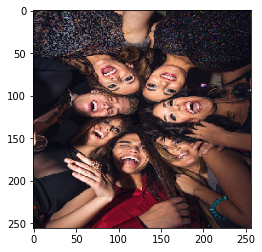

/content/MaskDataset/test/11136.jpg
1
17524.jpg


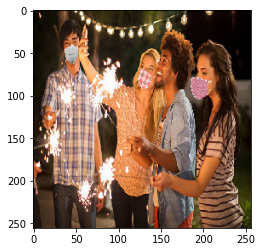

/content/MaskDataset/test/16956.jpg
1
14422.jpg


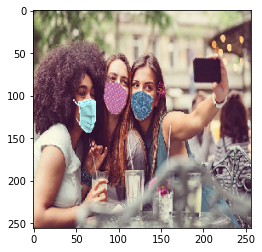

/content/MaskDataset/test/11980.jpg
2
10853.jpg


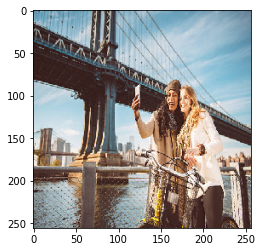

/content/MaskDataset/test/11904.jpg
1
18078.jpg


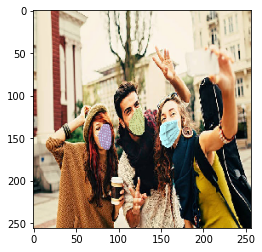

/content/MaskDataset/test/11222.jpg
2
13938.jpg


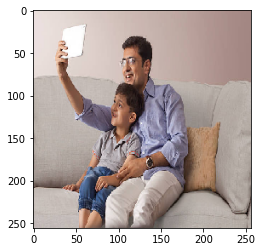

/content/MaskDataset/test/11616.jpg
1
16966.jpg


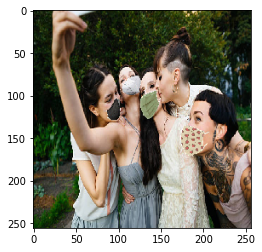

/content/MaskDataset/test/14648.jpg
1
11680.jpg


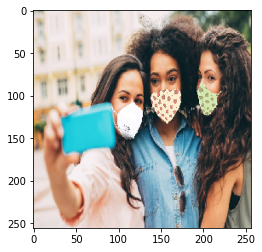

/content/MaskDataset/test/13475.jpg
2
15710.jpg


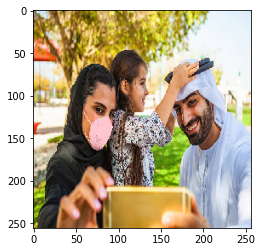

/content/MaskDataset/test/12717.jpg
2
16259.jpg


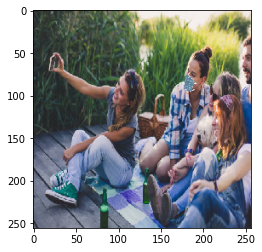

In [ ]:
#@title
from PIL import Image
test_images_paths = os.listdir(test_dir)
# painted_masks = os.path.join(custom_data_dir, "painted masks")
# beards= os.path.join(custom_data_dir, "beards")
# test_images_paths = os.listdir(beards)

for i in range(10):
  image_path = os.path.join(test_dir, test_images_paths[-i])
  print(image_path)
  img = tf.keras.preprocessing.image.load_img(
      image_path, grayscale=False, color_mode="rgb", target_size=(256,256), interpolation="nearest"
  )
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0)

  predictions = model_1.predict(img_array)
  score=tf.nn.softmax(predictions[0])
  pred1 = tf.nn.softmax(predictions)
  pred1 = np.argmax(pred1)
  if (pred1):
    pred2 = model_2.predict(img_array)
    pred2 = tf.nn.softmax(pred2[0])
    pred2 = np.argmax(pred2)
    if (pred2):
      print("SOME")
    elif (not pred2):
      print("NONE")
  else:
    print("ALL")


  print(test_images_paths[i])
  plt.imshow(img)
  plt.show()

## Create output

In [ ]:
#currently this is configured for the 2 part model
# model = tf.keras.models.load_model('/content/drive/My Drive/Colab Data/saved_model_homework1')
results = {}
for i in os.listdir(test_dir):
  img = tf.keras.preprocessing.image.load_img("/content/MaskDataset/test/"+i, target_size=(m_img_h, m_img_w))
  img_array = tf.keras.preprocessing.image.img_to_array(img) / 255
  img_array = tf.expand_dims(img_array, 0)#create a batch from this one image
  predictions = model_1.predict(img_array)
  score=tf.nn.softmax(predictions[0])
  pred1 = tf.nn.softmax(predictions)
  pred1 = np.argmax(pred1)
  if (pred1):
    pred2 = model_2.predict(img_array)
    pred2 = tf.nn.softmax(pred2[0])
    pred2 = np.argmax(pred2)
    if (pred2):
      results[i] = 2
    elif (not pred2):
      results[i] = 0
  else:
    results[i] = 1
  # predicted_class_int = np.argmax(predictions[0])
  # results[i] = predicted_class_int
  print(i, results[i], score)


import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

create_csv(results)

In [ ]:
from google.colab import files
!ls
files.download("results_Nov21_14-23-44.csv")

drive	     results_Nov21_14-08-42.csv  sample_data
MaskDataset  results_Nov21_14-23-44.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>